# **ViT Implementation (from scratch):**

***author:** Mohamed Behery*<br/>
***email:** m.behery@live.com*<br/>
***Phone/Skype Username:** +201062989114*

## **Implementation Methodology:**

This code was developed after following the details and explanations featured in the following articles:

**Title:** Mastering BERT Model: Building it from Scratch with Pytorch<br/>
**URL:**   *https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891*

**Title:** Vision Transformers from Scratch (PyTorch): A step-by-step guide<br/>
**URL:**   *https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c*

For implementing the architecture on the CIFAR100 dataset the following tutorial was followed:

**Title:** Image classification with Vision Transformer<br/>
**URL:**   *https://keras.io/examples/vision/image_classification_with_vision_transformer/*

Where the code featured in this notebook:

>- was developed almost entirely while examining the figures and diagrams originally attached in those articles and also attached here for reference while developing.

>- uses the best out of these articles for efficient performance, and it features a more efficient implementation to the "patchify" function, as hinted to in the PyTorch's ViT article attached.

After following the two articles featuring ViT, <font color = 'red'> **discrepencies were found when implementing core concepts**</font>. For which the following academic paper was investigated:

**Title:** An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale<br/>
**URL:**   *https://arxiv.org/abs/2010.11929*

From which the paper was used as the primary source for revising the code and modifying it accordingly and the first three articles were used to fill in the gaps in details not covered directly by the paper.

The below code was developed almost entirely while examining the figures and diagrams originally attached in those articles and also attached here for reference while developing.

## **Conclusion:**

To implement the architecture specified for the ViT in the aforementioned research paper on the local GPU (RTX-2060), the batch size will have to be 18 data points. In the paper the batch size was 4000+ datapoints on 10,000 epochs for training on the CIFAR100. Which means that for the model to converge with the CIFAR100 while training at a batch size of 18 data points it will take way way more iterations on mini-batches which could easily make the 10,000 epochs needed for the 4000-point batch size become 100,000+ epochs for the 18-point one. Which could take this hardware at least 1 year to complete!

Still, trying this with a much simplified architecture with a 256-point batch size eventually using 98% of the RTX-2060, the mode appears to saturate at around 37% validation accuracy instead of saturating at 28% for an even more simplified architecture.

In [1]:
import numpy as np
from tqdm import tqdm, trange
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Lambda, v2
from torchvision.datasets.cifar import CIFAR100
from nvidia_smi import nvmlInit, nvmlShutdown, nvmlDeviceGetHandleByIndex as nvmlGetHandle, nvmlDeviceGetMemoryInfo as nvmlGetMemory
from psutil import virtual_memory
from os.path import isfile

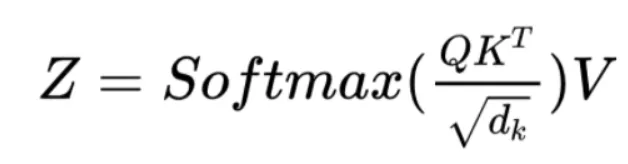

*Source: https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891*

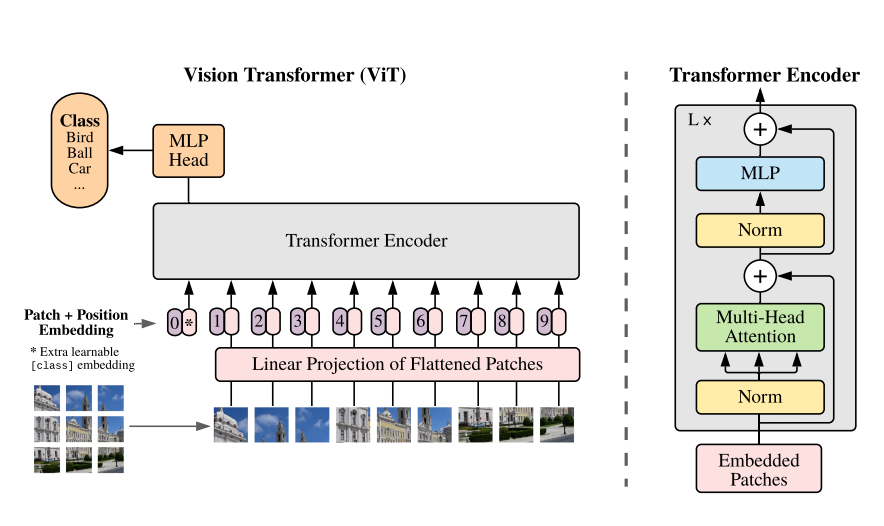

*Source: https://arxiv.org/abs/2010.11929*

In [2]:
class EncoderLayer(nn.Module):

    def __init__(self, seq_len, d_embedding, d_hidden_scale, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(normalized_shape = d_embedding)
        self.msa = EncoderLayer.MSA(d_embedding, n_heads)
        self.ln2 = nn.LayerNorm(normalized_shape = d_embedding)
        d_hidden = d_hidden_scale * d_embedding
        self.mlp = nn.Sequential(
            nn.Linear(d_embedding, d_hidden),
            nn.GELU(),
            nn.Dropout(0.0),
            nn.Linear(d_hidden, d_embedding),
            nn.GELU(),
            nn.Dropout(0.0),
        )
        
    def forward(self, z0):
        z = self.msa(self.ln1(z0)) + z0
        z = self.mlp(self.ln2(z)) + z
        return z
    
    class MSA(nn.Module):
        
        def __init__(self, d_embedding, n_heads):
            assert d_embedding % n_heads == 0, 'Vector embeddings should be evenly divided on the number of heads.'
            super().__init__()
            self.d_head = d_embedding // n_heads
            self.d_embedding = d_embedding
            self.n_heads = n_heads
            self.q_mapping = nn.Linear(d_embedding, d_embedding)
            self.k_mapping = nn.Linear(d_embedding, d_embedding)
            self.v_mapping = nn.Linear(d_embedding, d_embedding)
            self.softmax = nn.Softmax(dim = -1)
            self.dropout = nn.Dropout(0.0)
            
        def forward(self, z0):
            _, seq_len, _ = z0.shape
            q = self.q_mapping(z0).reshape(-1, seq_len, self.n_heads, self.d_head).transpose(1, 2)
            k = self.k_mapping(z0).reshape(-1, seq_len, self.n_heads, self.d_head).transpose(1, 2)
            v = self.v_mapping(z0).reshape(-1, seq_len, self.n_heads, self.d_head).transpose(1, 2)
            z = self.dropout(self.softmax(q @ k.transpose(2, 3) / self.d_head ** 0.5)) @ v
            return z.transpose(1, 2).reshape(-1, seq_len, self.d_embedding)

In [3]:
class ViT(nn.Module):

    def __init__(self, chw, n_patches, d_embedding, d_hidden_scale, n_heads, n_encoder_layers, mode, n_classes):
        
        assert mode in ['cls', 'gap']
        
        super().__init__()
        seq_len = n_patches ** 2 + 1
        self.mode = mode
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.n_patches = n_patches
        self.patch_embedding = nn.Linear(chw[0] * chw[1] * chw[2] // n_patches ** 2, d_embedding)
        self.positional_embeddings = nn.Parameter(data = self.__get_positional_embeddings(n_patches ** 2, d_embedding), requires_grad = True)
        self.dropout1 = nn.Dropout(0.0)
        self.class_token = nn.Parameter(data = torch.randn(1, 1, d_embedding), requires_grad = True)
        self.encoder = nn.Sequential(*[EncoderLayer(seq_len, d_embedding, d_hidden_scale, n_heads) for _ in range(n_encoder_layers)])
        self.ln = nn.LayerNorm(normalized_shape = d_embedding)
        self.dropout2 = nn.Dropout(0.0)
        d_hidden = d_hidden_scale * d_embedding
        self.mlp = nn.Sequential(
            nn.Linear(d_embedding, d_hidden),
            nn.Tanh(),
            nn.Dropout(0.0),
            nn.Linear(d_hidden, n_classes),
            nn.Dropout(0.0)
        )
        super().to(self.device)
    
    def forward(self, images):
        patches = self.__patchify(images, self.n_patches).to(self.device)
        embeddings = self.dropout1(torch.cat([self.class_token.repeat(images.shape[0], 1, 1), self.patch_embedding(patches)], dim = 1) + self.positional_embeddings)
        encoded = self.encoder(embeddings)
        match self.mode:
            case 'cls':
                context = self.ln(encoded[:, 0])
            case _:
                context = torch.mean(encoded, dim = -2)
        context = self.dropout2(context)
        result = self.mlp(context)
        return result
    
    @staticmethod
    def __patchify(images, n):
        N, C, H, W = images.shape
        assert (H % n == 0) and (W % n == 0), 'Image dimensions should be divisible by the desired number of patches.'
        h, w = H // n, W // n
        return images.unfold(2, h, h).unfold(3, w, w).permute(0, 2, 3, 1, 4, 5).reshape(N, -1, C * h * w)
    
    @staticmethod
    def __get_positional_embeddings(n, d):
        p_ = lambda i, j: torch.tensor(i / 10_000 ** (((j - 1) if j % 2 else j) / d))
        p = lambda i, j: torch.cos(p_(i, j)) if j % 2 else torch.sin(p_(i, j))
        out = torch.empty(n + 1, d)
        for i in range(n + 1):
            for j in range(d):
                out[i, j] = p(i, j)
        return out.unsqueeze(dim = 0)

In [4]:
torch.mean(torch.randn(32, 60, 64), dim = -2).shape

torch.Size([32, 64])

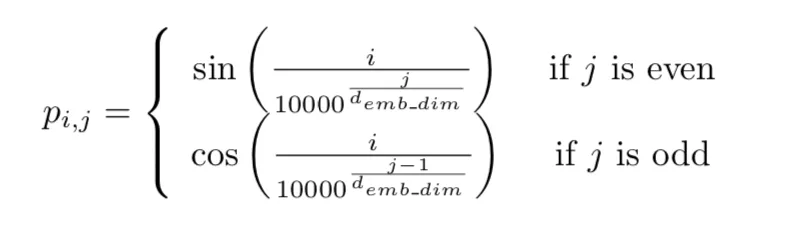

*Source: https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891*

In [5]:
def get_correct(y, y_pred):
    return (y_pred.argmax(1) == y.argmax(1)).sum().item()
    
def get_correct_k(y, y_pred, k):
    return (((torch.argsort(y_pred, dim = -1, descending = True) < k).type(torch.int) * y).argmax(1) == y.argmax(1)).sum().item()

def get_ram_used(device):
    assert device in ['cpu', 'cuda']
    if device == 'cpu':
        return virtual_memory()[2] / 100
    else:
        info = nvmlGetMemory(nvmlGetHandle(0))
        return info.used / info.total

def train_loop(train_loader, model, optimizer, criterion, epoch_idx, n_epochs):
    
    cum_loss, correct, correct_5, count = 0.0, 0, 0, 0
    n_batches = len(train_loader)
    
    model.train()
    for i, (x, y) in enumerate(train_loader):
        
        y = y.to(model.device)
        y_pred = nn.functional.softmax(model(x), dim = -1)
        
        loss = criterion(y_pred, y)
        cum_loss += loss.item()
        correct += get_correct(y, y_pred)
        correct_5 += get_correct_k(y, y_pred, 5)
        count += x.shape[0]
        cost, accuracy, accuracy_5 = cum_loss / count, correct / count, correct_5 / count
        
        print(f'\rMemory [{get_ram_used(model.device):.1%}] - Epoch [{epoch_idx + 1}/{n_epochs}] - Batch [{i + 1}/{n_batches}]:\tTrain Cost: {cost:.05f} | Train Accuracy: {accuracy:.1%}', end = '')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print()
    return cost, accuracy

def valid_loop(valid_loader, model, criterion, epoch_idx, n_epochs):
        
    cum_loss, correct, correct_5, count = 0.0, 0, 0, 0
    n_batches = len(valid_loader)
    
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_loader):
            
            y = y.to(model.device)
            y_pred = nn.functional.softmax(model(x), dim = -1)
        
            loss = criterion(y_pred, y)
            cum_loss += loss.item()
            correct += get_correct(y, y_pred)
            correct_5 += get_correct_k(y, y_pred, 5)
            count += x.shape[0]
            cost, accuracy, accuracy_5 = cum_loss / count, correct / count, correct_5 / count
            
            print(f'\rMemory [{get_ram_used(model.device):.1%}] - Epoch [{epoch_idx + 1}/{n_epochs}] - Batch [{i + 1}/{n_batches}]:\tValid Cost: {cost:.05f} | Valid Accuracy: {accuracy:.1%}', end = '')
    
    print()
    return cost, accuracy

In [6]:
class AugmentedCIFAR100(Dataset):

    def __init__(self, train):

        self.train = train
        
        self.data = CIFAR100(
            root = './data',
            train = train,
            download = True,
            transform = ToTensor(),
            target_transform = Lambda(lambda y: torch.zeros(100, dtype = torch.float).scatter_(dim = 0, index = torch.tensor(y), value = 1))
        )
        
        self.augment = v2.Compose([
            v2.RandomHorizontalFlip(p = 0.5),
            v2.RandomRotation(degrees = 7.2),
            v2.RandomResizedCrop(size = (32, 32), scale = (0.5, 1.0), ratio = (0.8, 1.2), antialias = True),
            v2.Normalize(mean = [0, 0, 0], std = [1, 1, 1]),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        x, y = self.data[item]
        return self.augment(x) if self.train else x, y

In [7]:
def train(model, criterion, optimizer, dataloaders, n_epochs):

    if model.device == 'cuda':
        nvmlInit()

    export_path = f'./model_state_dict__{model.mode}.pth'
    
    def load_best():
        if isfile(export_path):
            model.load_state_dict(torch.load(export_path))
        return model
        
    test_loader, train_loader = dataloaders
    model = load_best()
    
    print(f'\nTraining on: {torch.cuda.get_device_name() if model.device == "cuda" else "CPU"}\n')
    
    max_acc = 0.0
    for epoch_idx in range(n_epochs):
        
        try:
            
            train_cost, train_acc = train_loop(train_loader, model, optimizer, criterion, epoch_idx, n_epochs)
            valid_cost, valid_acc = valid_loop(test_loader, model, criterion, epoch_idx, n_epochs)
            
            if valid_acc > max_acc:
                max_acc = valid_acc
                torch.save(model.state_dict(), export_path)
                
            print('-' * 120)
            
        except KeyboardInterrupt:
            if model.device == 'cuda':
                nvmlShutdown()
            return load_best()
    
    if model.device == 'cuda':
        nvmlShutdown()        
    return load_best()

In [ ]:
dataloaders = [DataLoader(AugmentedCIFAR100(train), 1024, True) for train in [0, 1]]

model =  ViT(
    chw = dataloaders[0].dataset[0][0].shape, 
    n_patches = 8, 
    d_embedding = 256, 
    d_hidden_scale = 4, 
    n_heads = 8, 
    n_encoder_layers = 4, 
    mode = 'cls', 
    n_classes = 100
)

criterion = CrossEntropyLoss()

optimizer = Adam(
    params = model.parameters(),
    lr = 1e-4
)

model = train(model, criterion, optimizer, dataloaders, n_epochs = 100_000)

Files already downloaded and verified
Files already downloaded and verified

Training on: NVIDIA GeForce RTX 2060

Memory [97.0%] - Epoch [1/100000] - Batch [49/49]:	Train Cost: 0.00405 | Train Accuracy: 50.2%
Memory [97.0%] - Epoch [1/100000] - Batch [10/10]:	Valid Cost: 0.00429 | Valid Accuracy: 34.1%
------------------------------------------------------------------------------------------------------------------------
Memory [97.1%] - Epoch [2/100000] - Batch [49/49]:	Train Cost: 0.00404 | Train Accuracy: 51.2%
Memory [97.0%] - Epoch [2/100000] - Batch [10/10]:	Valid Cost: 0.00429 | Valid Accuracy: 34.1%
------------------------------------------------------------------------------------------------------------------------
Memory [97.2%] - Epoch [3/100000] - Batch [49/49]:	Train Cost: 0.00404 | Train Accuracy: 51.1%
Memory [97.2%] - Epoch [3/100000] - Batch [10/10]:	Valid Cost: 0.00429 | Valid Accuracy: 33.8%
-------------------------------------------------------------------------